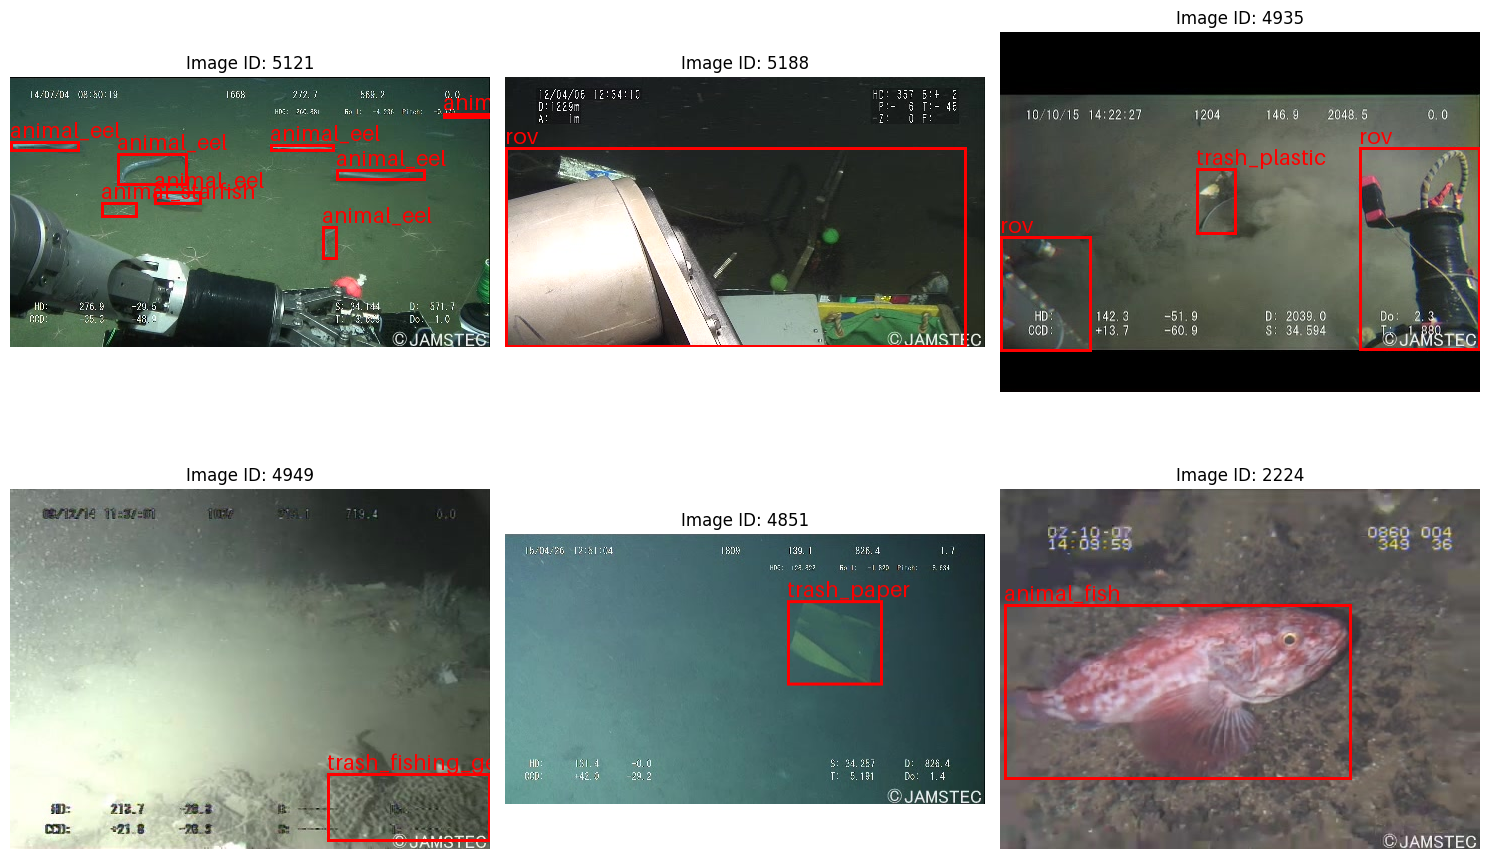

In [4]:
import json
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

# Paths to your dataset
image_folder = "../dataset/material_version/train/"
annotations_file = "../dataset/material_version/instances_train_trashcan.json"

# Load the annotations
with open(annotations_file, "r") as f:
    data = json.load(f)

# Load the images and annotations
images = data["images"]
annotations = data["annotations"]

id_to_name = {category["id"]: category["name"] for category in data["categories"]}

# Create a mapping from image_id to its annotations
image_to_annotations = {}
for annotation in annotations:
    image_id = annotation["image_id"]
    if image_id not in image_to_annotations:
        image_to_annotations[image_id] = []
    image_to_annotations[image_id].append(annotation)

# Select six images to display
selected_images = random.sample(images, 6)

# Plot the images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Set up the font for drawing text
font = ImageFont.load_default(
    size=22
)  # Fallback to default font if TrueType font is not available

for idx, img_info in enumerate(selected_images):
    image_id = img_info["id"]
    image_path = os.path.join(image_folder, img_info["file_name"])

    # Open the image
    img = Image.open(image_path)

    # Draw the bounding boxes
    draw = ImageDraw.Draw(img)
    if image_id in image_to_annotations:
        for annotation in image_to_annotations[image_id]:
            bbox = annotation["bbox"]  # [x, y, width, height]
            x, y, w, h = bbox
            draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

            # Add the class name with a larger font
            category_id = annotation["category_id"]
            category = id_to_name[category_id]
            draw.text(
                (x, y - 25), category, fill="red", font=font
            )  # Adjust vertical offset for visibility

    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title(f"Image ID: {image_id}")
    axes[idx].axis("off")

# Hide unused subplots
for ax in axes[len(selected_images) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
import os
import json
from PIL import Image
from tqdm import tqdm

# Paths to your dataset
image_folder = "../dataset/material_version/train/"
annotations_file = "../dataset/material_version/instances_train_trashcan.json"
output_folder = "../cropped_dataset/"
padding_factor = 0.45  # Percentage of the bounding box size to pad
padding_max = 100  # Maximum padding in pixels

# Load the annotations
with open(annotations_file, "r") as f:
    data = json.load(f)

# Extract categories and create id-to-name mapping
categories = data["categories"]
id_to_name = {category["id"]: category["name"] for category in categories}

# Ensure output directories exist
os.makedirs(output_folder, exist_ok=True)
for category_name in id_to_name.values():
    os.makedirs(os.path.join(output_folder, category_name), exist_ok=True)

# Create a new annotations mapping
new_annotations = {category_name: [] for category_name in id_to_name.values()}

# Process each image
for img_info in tqdm(data["images"], desc="Processing images"):
    image_id = img_info["id"]
    image_path = os.path.join(image_folder, img_info["file_name"])
    img = Image.open(image_path)

    # Get annotations for this image
    annotations = [
        ann for ann in data["annotations"] if ann["image_id"] == image_id
    ]

    for ann in annotations:
        category_id = ann["category_id"]
        category_name = id_to_name[category_id]
        bbox = ann["bbox"]  # [x, y, width, height]

        # Compute padding based on percentage
        x, y, w, h = bbox
        padding_x = min(int(w * padding_factor), padding_max)
        padding_y = min(int(h * padding_factor), padding_max)

        # Compute the crop region
        left = max(0, int(x) - padding_x)
        top = max(0, int(y) - padding_y)
        right = min(img.width, int(x + w) + padding_x)
        bottom = min(img.height, int(y + h) + padding_y)

        # Crop the image
        cropped_img = img.crop((left, top, right, bottom))

        # Save the cropped image
        cropped_img_name = f"{image_id}_{ann['id']}.jpg"
        cropped_img_path = os.path.join(output_folder, category_name, cropped_img_name)
        cropped_img.save(cropped_img_path)

        # Update the bounding box coordinates relative to the cropped image
        new_bbox = [
            x - left,
            y - top,
            w,
            h,
        ]

        # Add the new annotation
        new_annotations[category_name].append({
            "file_name": cropped_img_name,
            "bbox": new_bbox,
            "category_id": category_id,
            "category_name": category_name,
        })

# Save new JSON files for each category
for category_name, annotations in new_annotations.items():
    output_json_path = os.path.join(output_folder, category_name, f"bboxes.json")
    with open(output_json_path, "w") as f:
        json.dump({"annotations": annotations}, f, indent=4)

print(f"New dataset created at {output_folder}")

Processing images: 100%|██████████| 6008/6008 [00:24<00:00, 240.92it/s]


New dataset created at ../cropped_dataset/


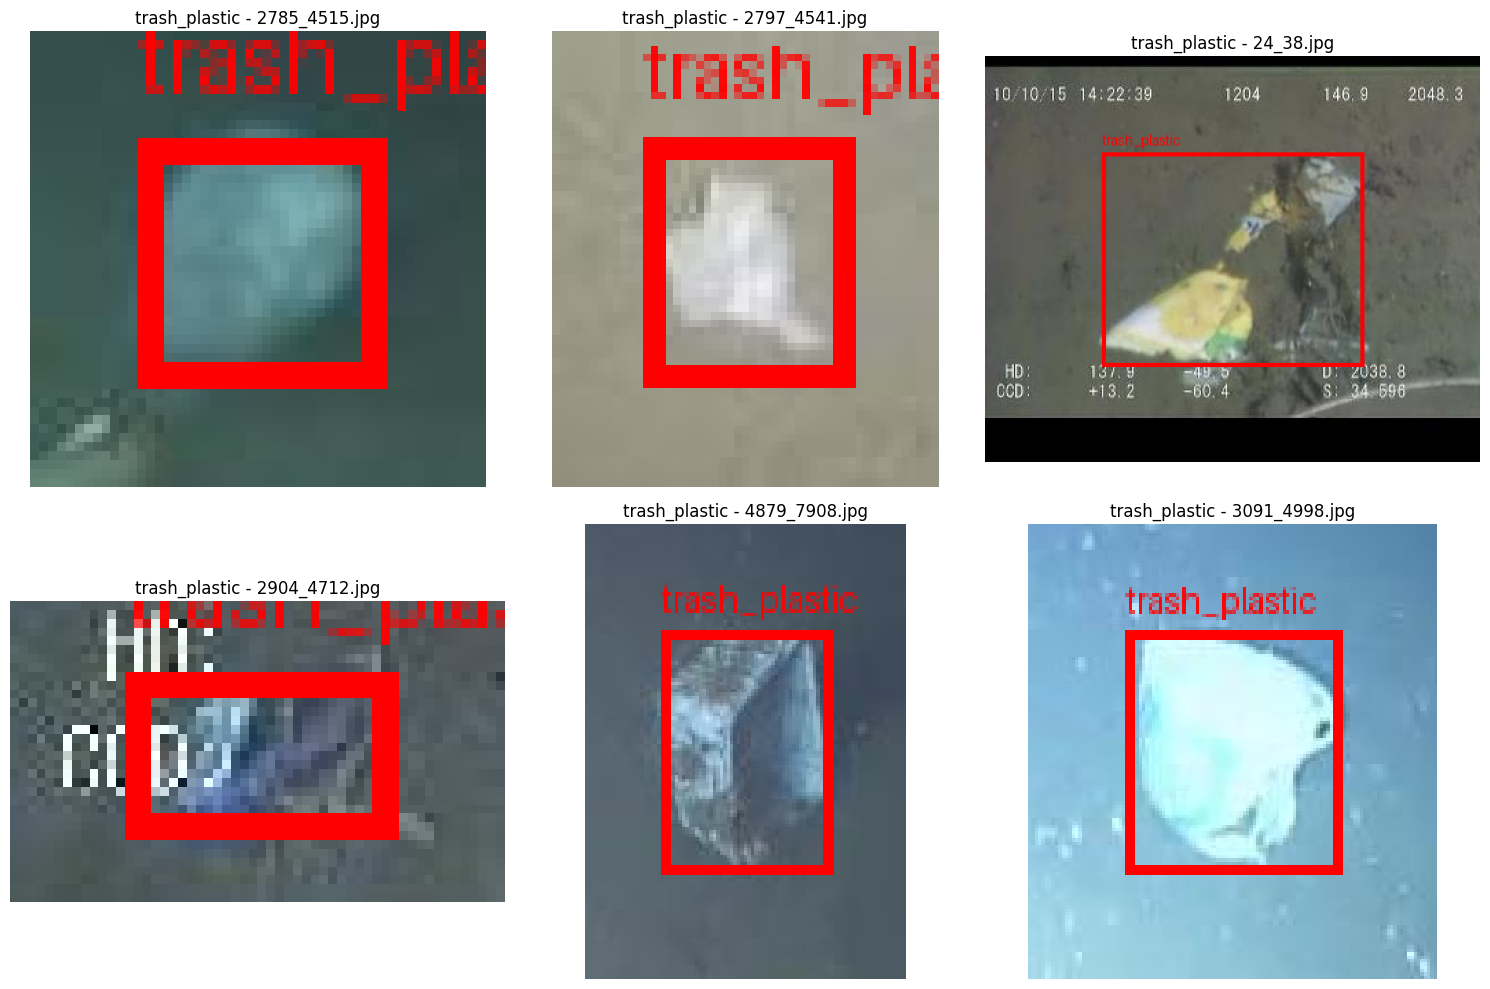

In [7]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

# Path to the new dataset
cropped_dataset_folder = "../cropped_dataset/"

# Font setup for text
try:
    font = ImageFont.truetype("arial.ttf", size=16)
except IOError:
    font = ImageFont.load_default()

# Iterate over class folders
categories = [d for d in os.listdir(cropped_dataset_folder) if os.path.isdir(os.path.join(cropped_dataset_folder, d))]

# Randomly select a category
selected_category = "trash_plastic"
category_folder = os.path.join(cropped_dataset_folder, selected_category)

# Load the JSON file for the selected category
json_path = os.path.join(category_folder, f"bboxes.json")
with open(json_path, "r") as f:
    annotations = json.load(f)["annotations"]

# Randomly select six images to display
selected_annotations = random.sample(annotations, min(6, len(annotations)))

# Plot the images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, annotation in enumerate(selected_annotations):
    img_path = os.path.join(category_folder, annotation["file_name"])
    img = Image.open(img_path)

    # Draw bounding box
    draw = ImageDraw.Draw(img)
    bbox = annotation["bbox"]
    x, y, w, h = bbox
    draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
    draw.text((x, y - 15), annotation["category_name"], fill="red", font=font)

    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title(f"{annotation['category_name']} - {annotation['file_name']}")
    axes[idx].axis("off")

# Hide unused subplots
for ax in axes[len(selected_annotations):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import json
import random
from PIL import Image
from tqdm import tqdm

# Paths
output_folder = "../dataset_finetuning/train/"
cropped_dataset_folder = "../cropped_dataset/"
categories = ["trash_metal", "trash_plastic", "trash_wood", "trash_etc", "trash_fabric", "trash_fishing_gear"]
labels = {
    "trash_metal": "A metal trash underwater",
    "trash_paper": "A paper trash underwater",
    "trash_plastic": "A plastic trash underwater",
    "trash_rubber": "A rubber trash underwater",
    "trash_wood": "A wood trash underwater",
    "trash_etc": "A trash underwater",
    "trash_fabric": "A fabric trash underwater",
    "trash_fishing_gear": "A fishing gear trash underwater",
}

N = 50
min_size = 150

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over categories
for category in categories:
    category_folder = os.path.join(output_folder, category)
    os.makedirs(category_folder, exist_ok=True)
    source_category_folder = os.path.join(cropped_dataset_folder, category)
    json_file = os.path.join(source_category_folder, "bboxes.json")
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"JSON file not found for category: {category}")
    with open(json_file, "r") as f:
        data = json.load(f)
    valid_images = []
    for annotation in data["annotations"]:
        img_path = os.path.join(source_category_folder, annotation["file_name"])
        if os.path.exists(img_path):
            with Image.open(img_path) as img:
                width, height = img.size
                if width > min_size and height > min_size:
                    valid_images.append({
                        "file_name": annotation["file_name"],
                        "bbox": annotation["bbox"],
                        "category_id": annotation["category_id"],
                        "category_name": annotation["category_name"],
                    })
    if len(valid_images) < N:
        raise ValueError(
            f"Not enough valid images in category '{category}'. Found {len(valid_images)}, required {N}."
        )
    sampled_images = random.sample(valid_images, N)
    for img_info in tqdm(sampled_images, desc=f"Copying sampled images for {category}"):
        src_path = os.path.join(source_category_folder, img_info["file_name"])
        dest_path = os.path.join(category_folder, img_info["file_name"])
        with Image.open(src_path) as img:
            img.save(dest_path)

output_csv_file = os.path.join(output_folder, "metadata.csv")
with open(output_csv_file, "w") as f:
    f.write("file_name,text\n")
    for category in categories:
        category_folder = os.path.join(output_folder, category)
        for file in os.listdir(category_folder):
            f.write(f"{category}/{file},{labels[category]}\n")

In [7]:
import os
import json
import random
from PIL import Image
from tqdm import tqdm

# Paths
output_folder = "../dataset_finetuning2/train/"
cropped_dataset_folder = "../cropped_dataset/"
categories = ["trash_metal", "trash_plastic", "trash_wood", "trash_etc", "trash_fabric", "trash_fishing_gear"]
labels = {
    "trash_metal": "A metal trash underwater",
    "trash_paper": "A paper trash underwater",
    "trash_plastic": "A plastic trash underwater",
    "trash_rubber": "A rubber trash underwater",
    "trash_wood": "A wood trash underwater",
    "trash_etc": "A trash underwater",
    "trash_fabric": "A fabric trash underwater",
    "trash_fishing_gear": "A fishing gear trash underwater",
}

#N = 50
N = 25
min_size = 256
#min_size = 150

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over categories
for category in categories:
    category_folder = os.path.join(output_folder, category)
    os.makedirs(category_folder, exist_ok=True)
    source_category_folder = os.path.join(cropped_dataset_folder, category)
    json_file = os.path.join(source_category_folder, "bboxes.json")
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"JSON file not found for category: {category}")
    with open(json_file, "r") as f:
        data = json.load(f)
    valid_images = []
    for annotation in data["annotations"]:
        img_path = os.path.join(source_category_folder, annotation["file_name"])
        if os.path.exists(img_path):
            with Image.open(img_path) as img:
                width, height = img.size
                if width > min_size and height > min_size:
                    valid_images.append({
                        "file_name": annotation["file_name"],
                        "bbox": annotation["bbox"],
                        "category_id": annotation["category_id"],
                        "category_name": annotation["category_name"],
                    })
    if len(valid_images) < N:
        raise ValueError(
            f"Not enough valid images in category '{category}'. Found {len(valid_images)}, required {N}."
        )
    sampled_images = random.sample(valid_images, N)
    for img_info in tqdm(sampled_images, desc=f"Copying sampled images for {category}"):
        src_path = os.path.join(source_category_folder, img_info["file_name"])
        dest_path = os.path.join(category_folder, img_info["file_name"])
        with Image.open(src_path) as img:
            img.save(dest_path)

output_csv_file = os.path.join(output_folder, "metadata.csv")
with open(output_csv_file, "w") as f:
    f.write("file_name,text\n")
    for category in categories:
        category_folder = os.path.join(output_folder, category)
        for file in os.listdir(category_folder):
            f.write(f"{category}/{file},{labels[category]}\n")

Copying sampled images for trash_fishing_gear: 100%|██████████| 25/25 [00:00<00:00, 384.48it/s]
